# XGBOOST

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [37]:

# Load dataset
data_xgboost = pd.read_csv('data_xgboost.csv')
data_xgboost = pd.DataFrame(data_xgboost)


# Convert 'CRASH_DATE' to datetime format and set it as the index
data_xgboost['CRASH_DATE'] = pd.to_datetime(data_xgboost['CRASH_DATE'])
# Aggregate data to get daily crash counts
data_xgboost.set_index('CRASH_DATE', inplace=True)
data_xgboost = data_xgboost.resample('H').size().to_frame(name='COUNT')

# Extract time-based features
data_xgboost['dayoftheweek'] = data_xgboost.index.dayofweek
data_xgboost['hour'] = data_xgboost.index.hour
data_xgboost['month'] = data_xgboost.index.month
data_xgboost['year'] = data_xgboost.index.year
data_xgboost['dayofthemonth'] = data_xgboost.index.day
data_xgboost['dayoftheyear'] = data_xgboost.index.dayofyear

# Fix for weekoftheyear to work on all pandas versions
data_xgboost['weekoftheyear'] = data_xgboost.index.to_series().dt.isocalendar().week


# Display the modified DataFrame
data_xgboost



C:\Users\byash\AppData\Local\Temp\ipykernel_46268\2307861490.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_xgboost = data_xgboost.resample('H').size().to_frame(name='COUNT')


,COUNT,dayoftheweek,hour,month,year,dayofthemonth,dayoftheyear,weekoftheyear
CRASH_DATE,,,,,,,,
2016-01-01 00:00:00,5,4,0,1,2016,1,1,53
2016-01-01 01:00:00,8,4,1,1,2016,1,1,53
2016-01-01 02:00:00,9,4,2,1,2016,1,1,53
2016-01-01 03:00:00,5,4,3,1,2016,1,1,53
2016-01-01 04:00:00,4,4,4,1,2016,1,1,53
...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,14,1,19,12,2024,31,366,1
2024-12-31 20:00:00,16,1,20,12,2024,31,366,1
2024-12-31 21:00:00,7,1,21,12,2024,31,366,1


In [38]:

data_xgboost['lag1'] = data_xgboost['COUNT'].shift(1)  # Previous hour
data_xgboost['lag3'] = data_xgboost['COUNT'].shift(3)  # 3 hours ago
data_xgboost['lag6'] = data_xgboost['COUNT'].shift(6)  # 6 hours ago
data_xgboost['lag12'] = data_xgboost['COUNT'].shift(12)  # Half-day (12 hours)
data_xgboost['lag24'] = data_xgboost['COUNT'].shift(24)  # 1-day lag

In [39]:

data_xgboost['rolling_mean_6'] = data_xgboost['COUNT'].rolling(window=6).mean()
data_xgboost['rolling_mean_12'] = data_xgboost['COUNT'].rolling(window=12).mean()
data_xgboost['rolling_mean_24'] = data_xgboost['COUNT'].rolling(window=24).mean()
data_xgboost['expanding_mean'] = data_xgboost['COUNT'].expanding().mean()


[0]	validation_0-rmse:13.17527	validation_1-rmse:14.53530
[1]	validation_0-rmse:12.82641	validation_1-rmse:14.15316
[2]	validation_0-rmse:12.48753	validation_1-rmse:13.78058
[3]	validation_0-rmse:12.16322	validation_1-rmse:13.42566
[4]	validation_0-rmse:11.84452	validation_1-rmse:13.07628
[5]	validation_0-rmse:11.54536	validation_1-rmse:12.74862
[6]	validation_0-rmse:11.25261	validation_1-rmse:12.42819
[7]	validation_0-rmse:10.97239	validation_1-rmse:12.12016
[8]	validation_0-rmse:10.69428	validation_1-rmse:11.81518
[9]	validation_0-rmse:10.43107	validation_1-rmse:11.52584
[10]	validation_0-rmse:10.17489	validation_1-rmse:11.24567
[11]	validation_0-rmse:9.92941	validation_1-rmse:10.97510
[12]	validation_0-rmse:9.69229	validation_1-rmse:10.71502
[13]	validation_0-rmse:9.46023	validation_1-rmse:10.45974
[14]	validation_0-rmse:9.23936	validation_1-rmse:10.21726
[15]	validation_0-rmse:9.02459	validation_1-rmse:9.98209
[16]	validation_0-rmse:8.81889	validation_1-rmse:9.75541
[17]	validation

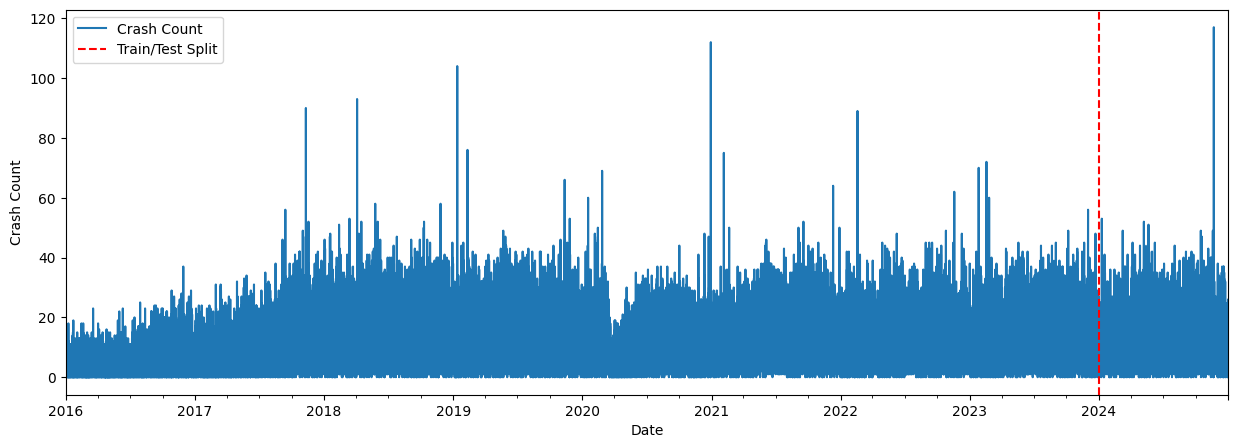

In [40]:
from xgboost import XGBRegressor

# Splitting the dataset
train = data_xgboost.iloc[data_xgboost.index< "2024-01-01"]
test = data_xgboost.iloc[data_xgboost.index >= "2024-01-01"]

FEATURES = [
    'dayoftheyear', 'hour', 'dayoftheweek', 'month', 'year', 
    'dayofthemonth', 'weekoftheyear',  # Existing features
    'lag1', 'lag3', 'lag6', 'lag12', 'lag24',  # Short-term dependencies
    'rolling_mean_6', 'rolling_mean_12', 'rolling_mean_24',  # Smoothed trends
    'expanding_mean'  # Long-term trend
]
TARGET = 'COUNT'

# Define Model
reg = XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=700,  # 🔹 Reduce to prevent overfitting
    learning_rate=0.03,  # 🔹 Lower learning rate for better generalization
    max_depth=6,  # 🔹 Slightly deeper trees (more data supports this)
    subsample=0.8,  # 🔹 Use only 80% of data per tree (prevents overfitting)
    colsample_bytree=0.8,  # 🔹 Use 80% of features per tree (reduces redundancy)
    reg_lambda=10,  # 🔹 Stronger L2 regularization (prevents overfitting)
    reg_alpha=5,  # 🔹 L1 regularization (helps feature selection)
    early_stopping_rounds=20,  # 🔹 Stops training earlier if no improvement
    objective='reg:squarederror'
)

# Train Model (with early stopping)
reg.fit(
    train[FEATURES], train[TARGET],  # ✅ Training Data
    eval_set=[(train[FEATURES], train[TARGET]), (test[FEATURES], test[TARGET])],  # ✅ Validation Set
    verbose=True  # ✅ Show training progress
)

rr2 = reg.score(train[FEATURES], train[TARGET])
mse = mean_squared_error(test[TARGET], reg.predict(test[FEATURES]))
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {rr2}")

ax = data_xgboost[['COUNT']].plot(figsize=(15, 5))
plt.axvline(x=pd.Timestamp("2024-01-01"), linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Crash Count')
plt.legend(['Crash Count', 'Train/Test Split'])


In [41]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split(data_xgboost):
    train_fold, test_fold = data_xgboost.iloc[train_idx], data_xgboost.iloc[test_idx]
    
    reg = XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=700,  # 🔹 Reduce to prevent overfitting
    learning_rate=0.03,  # 🔹 Lower learning rate for better generalization
    max_depth=6,  # 🔹 Slightly deeper trees (more data supports this)
    subsample=0.8,  # 🔹 Use only 80% of data per tree (prevents overfitting)
    colsample_bytree=0.8,  # 🔹 Use 80% of features per tree (reduces redundancy)
    reg_lambda=10,  # 🔹 Stronger L2 regularization (prevents overfitting)
    reg_alpha=5,  # 🔹 L1 regularization (helps feature selection)
    early_stopping_rounds=20,  # 🔹 Stops training earlier if no improvement
    objective='reg:squarederror'
    )

    # ✅ Pass `eval_set` for early stopping
    reg.fit(
        train_fold[FEATURES], train_fold[TARGET],
        eval_set=[(test_fold[FEATURES], test_fold[TARGET])],  # ✅ Validation set required
        verbose=True
    )

    print(f"Test R²: {reg.score(test_fold[FEATURES], test_fold[TARGET])}")
    
from IPython.core.interactiveshell import InteractiveShell

# Set max lines displayed
InteractiveShell.ast_node_interactivity = "last_expr"




[0]	validation_0-rmse:15.06777
[1]	validation_0-rmse:14.78050
[2]	validation_0-rmse:14.51699
[3]	validation_0-rmse:14.26398
[4]	validation_0-rmse:14.00277
[5]	validation_0-rmse:13.80090
[6]	validation_0-rmse:13.55424
[7]	validation_0-rmse:13.36204
[8]	validation_0-rmse:13.14241
[9]	validation_0-rmse:12.95750
[10]	validation_0-rmse:12.75385
[11]	validation_0-rmse:12.57560
[12]	validation_0-rmse:12.38324
[13]	validation_0-rmse:12.18315
[14]	validation_0-rmse:12.01500
[15]	validation_0-rmse:11.86508
[16]	validation_0-rmse:11.69758
[17]	validation_0-rmse:11.53347
[18]	validation_0-rmse:11.36758
[19]	validation_0-rmse:11.20518
[20]	validation_0-rmse:11.06451
[21]	validation_0-rmse:10.90841
[22]	validation_0-rmse:10.77316
[23]	validation_0-rmse:10.63266
[24]	validation_0-rmse:10.50733
[25]	validation_0-rmse:10.38905
[26]	validation_0-rmse:10.25585
[27]	validation_0-rmse:10.12273
[28]	validation_0-rmse:10.00789
[29]	validation_0-rmse:9.90007
[30]	validation_0-rmse:9.79847
[31]	validation_0-rm

In [42]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_xgboost['COUNT'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] > 0.05:
    print("Time series is not stationary.")
else:
    print("Time series is stationary.")


ADF Statistic: -13.307769830561146
p-value: 6.842780454584551e-25
Time series is stationary.


R² Score: 0.8220229148864746


C:\Users\byash\AppData\Local\Temp\ipykernel_46268\1981575905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(test[FEATURES])


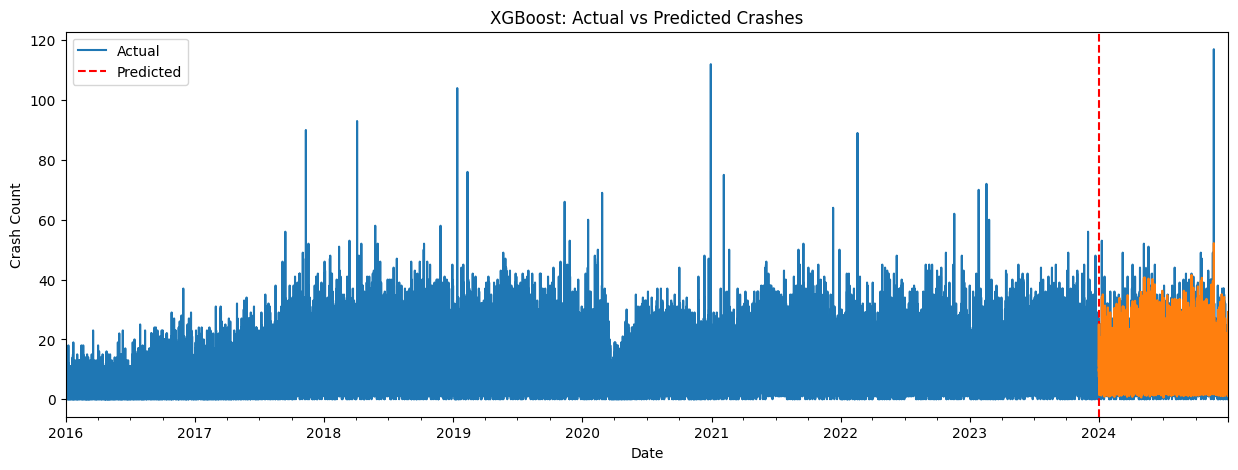

In [43]:
from sklearn.metrics import r2_score


# Drop existing 'prediction' columns to avoid merge conflict
test['prediction'] = reg.predict(test[FEATURES])
data_xgboost = data_xgboost.drop(columns=['prediction_x', 'prediction_y', 'prediction'], errors='ignore')

# Merge without conflicts
data_xgboost = data_xgboost.merge(test[['prediction']], how='left', left_index=True, right_index=True)
rr2 = r2_score(test[TARGET], test['prediction'])
print(f"R² Score: {rr2}")

# Plot results
ax = data_xgboost[['COUNT']].plot(figsize=(15, 5))
plt.axvline(x=pd.Timestamp("2024-01-01"), linestyle='--', color='red')
data_xgboost['prediction'].plot(ax=ax, style='-')

plt.title('XGBoost: Actual vs Predicted Crashes')
plt.xlabel('Date')
plt.ylabel('Crash Count')
plt.legend(['Actual', 'Predicted'])
plt.show()


In [44]:
rmse = np.sqrt(mean_squared_error(test[TARGET], test['prediction']))
print(f"RMSE: {rmse}")

RMSE: 3.5962519685264507


C:\Users\byash\AppData\Local\Temp\ipykernel_46268\1237945061.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trend'] = decompose.trend
C:\Users\byash\AppData\Local\Temp\ipykernel_46268\1237945061.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seasonal'] = decompose.seasonal
C:\Users\byash\AppData\Local\Temp\ipykernel_46268\1237945061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

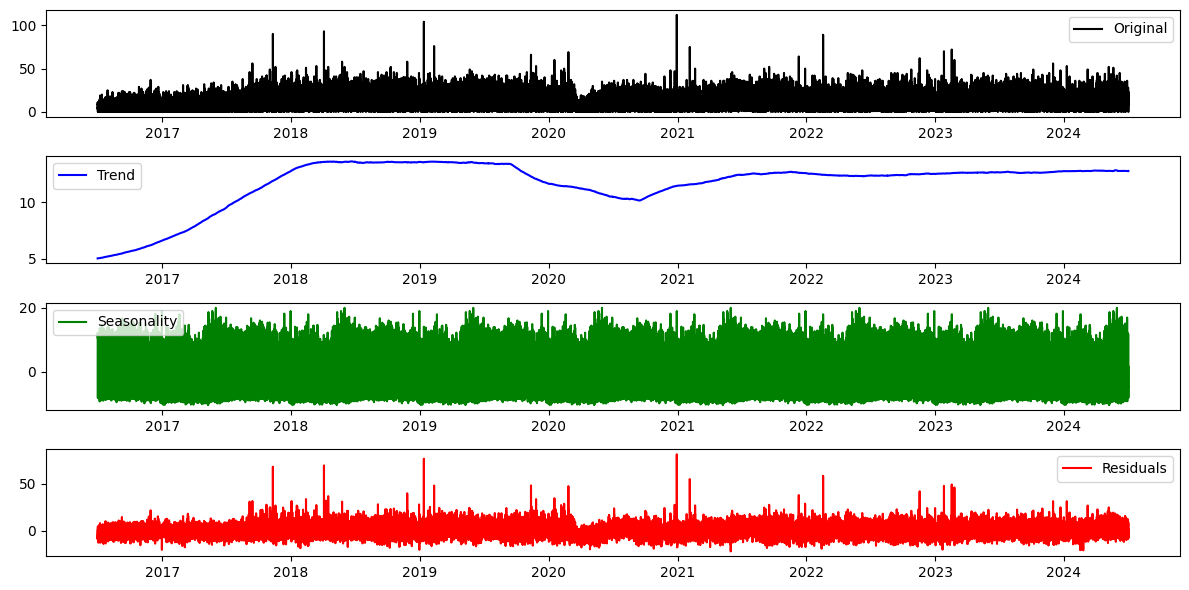

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = data_xgboost[['COUNT']]
decompose = seasonal_decompose(df['COUNT'], model='additive', period=8760)
df['trend'] = decompose.trend
df['seasonal'] = decompose.seasonal
df['residual'] = decompose.resid

df = df.dropna()


plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(df["COUNT"], label="Original", color="black")
plt.legend()
plt.subplot(412)
plt.plot(df['trend'], label="Trend", color="blue")
plt.legend()
plt.subplot(413)
plt.plot(df['seasonal'], label="Seasonality", color="green")
plt.legend()
plt.subplot(414)
plt.plot(df['residual'], label="Residuals", color="red")
plt.legend()
plt.tight_layout()
plt.show()


    

In [46]:
df['dayoftheweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofthemonth'] = df.index.day
df['dayoftheyear'] = df.index.dayofyear
df['weekoftheyear'] = df.index.to_series().dt.isocalendar().week


In [47]:
from sklearn.model_selection import TimeSeriesSplit

FEATURES = ['dayoftheyear', 'hour', 'dayoftheweek', 'month', 'year', 
        'dayofthemonth', 'weekoftheyear']

TARGET = 'residual'

tscv = TimeSeriesSplit(n_splits=6)

for train_idx, test_idx in tscv.split(df):
        train_fold, test_fold = df.iloc[train_idx], df.iloc[test_idx]
        
        reg = XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=300,  # 🔹 Reduce to prevent overfitting
        learning_rate=0.03,  # 🔹 Lower learning rate for better generalization
        max_depth=6,  # 🔹 Slightly deeper trees (more data supports this)
        subsample=0.8,  # 🔹 Use only 80% of data per tree (prevents overfitting)
        colsample_bytree=0.8,  # 🔹 Use 80% of features per tree (reduces redundancy)
        reg_lambda=10,  # 🔹 Stronger L2 regularization (prevents overfitting)
        reg_alpha=5,  # 🔹 L1 regularization (helps feature selection)
        early_stopping_rounds=20,  # 🔹 Stops training earlier if no improvement
        objective='reg:squarederror'
        )

        # ✅ Pass `eval_set` for early stopping
        reg.fit(
            train_fold[FEATURES], train_fold[TARGET],
            eval_set=[(test_fold[FEATURES], test_fold[TARGET])],  # ✅ Validation set required
            verbose=True
        )

        print(f"Test R²: {reg.score(test_fold[FEATURES], test_fold[TARGET])}")
        
df.loc[test_fold.index, "residual_forecast"] = reg.predict(test_fold[FEATURES])

[0]	validation_0-rmse:5.52264
[1]	validation_0-rmse:5.51197
[2]	validation_0-rmse:5.50269
[3]	validation_0-rmse:5.50245
[4]	validation_0-rmse:5.49979
[5]	validation_0-rmse:5.50638
[6]	validation_0-rmse:5.51352
[7]	validation_0-rmse:5.50781
[8]	validation_0-rmse:5.49964
[9]	validation_0-rmse:5.50733
[10]	validation_0-rmse:5.50820
[11]	validation_0-rmse:5.50278
[12]	validation_0-rmse:5.50344
[13]	validation_0-rmse:5.49633
[14]	validation_0-rmse:5.49470
[15]	validation_0-rmse:5.50285
[16]	validation_0-rmse:5.51112
[17]	validation_0-rmse:5.51014
[18]	validation_0-rmse:5.50920
[19]	validation_0-rmse:5.50268
[20]	validation_0-rmse:5.50214
[21]	validation_0-rmse:5.51027
[22]	validation_0-rmse:5.50779
[23]	validation_0-rmse:5.50704
[24]	validation_0-rmse:5.50569
[25]	validation_0-rmse:5.51308
[26]	validation_0-rmse:5.52023
[27]	validation_0-rmse:5.51630
[28]	validation_0-rmse:5.51344
[29]	validation_0-rmse:5.52286
[30]	validation_0-rmse:5.53069
[31]	validation_0-rmse:5.53644
[32]	validation_0-

In [48]:
df["final_forecast"] = df["residual_forecast"] + df["trend"] + df["seasonal"]


<Figure size 1200x500 with 0 Axes>

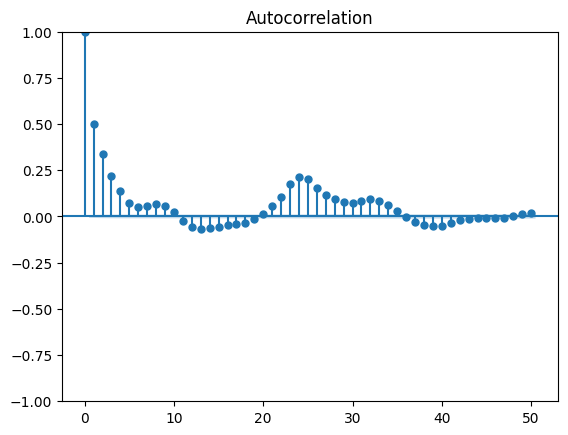

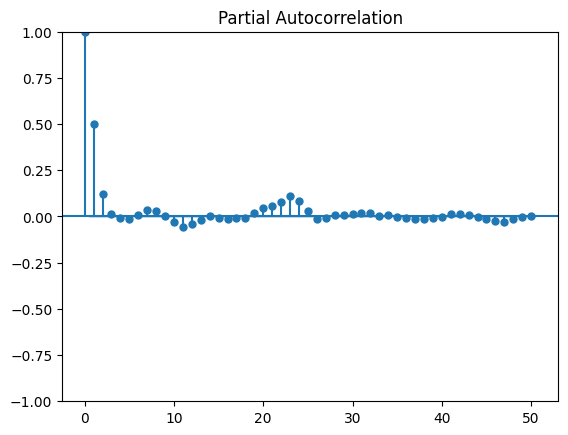

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plot_acf(df["residual"].dropna(), lags=50)  # Autocorrelation plot
plot_pacf(df["residual"].dropna(), lags=50)  # Partial autocorrelation plot
plt.show()


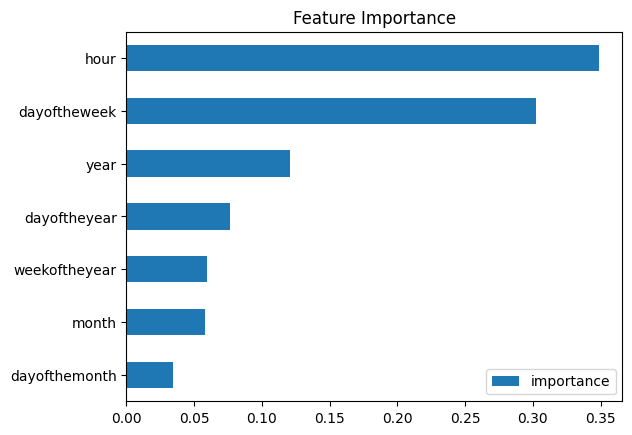

In [50]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

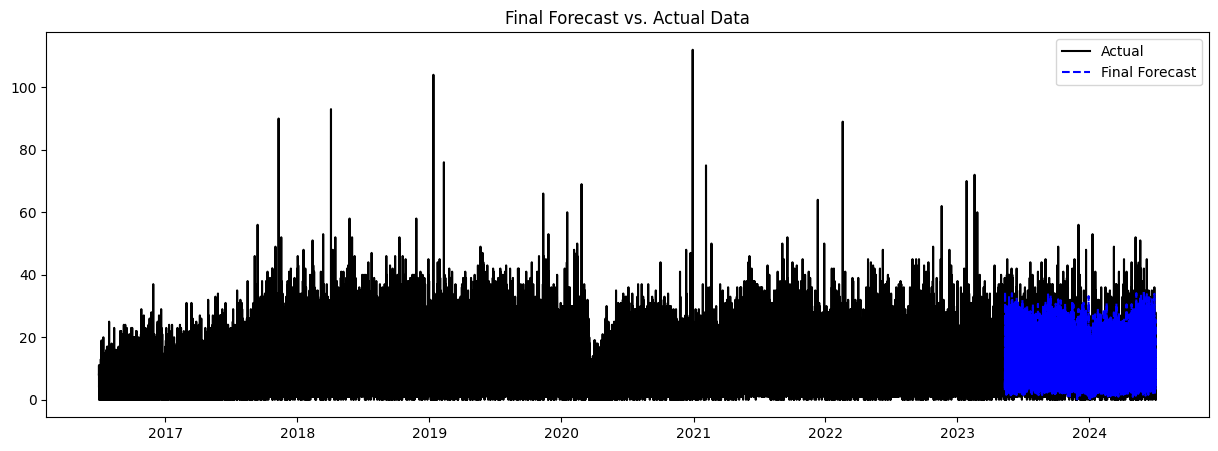

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df.index, df["COUNT"], label="Actual", color="black")
plt.plot(df.index, df["final_forecast"], label="Final Forecast", color="blue", linestyle="dashed")
plt.legend()
plt.title("Final Forecast vs. Actual Data")
plt.show()


In [52]:
from sklearn.metrics import r2_score
dc = df.loc[df['final_forecast'].notnull()]

# Compute R² score between actual COUNT and final forecast
r2 = r2_score(dc["COUNT"].dropna(), dc["final_forecast"].dropna())
print(f"Final R² Score: {r2:.4f}")


Final R² Score: 0.7595
